In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import utils

In [2]:
rotations = np.array([(np.pi/2 + n*np.pi/8)%(2*np.pi) for n in range(16)])
cardinals_map = dict(zip(utils.CARDINALS, rotations))

In [3]:
cardinals_map

{'N': 1.5707963267948966,
 'NNE': 1.9634954084936207,
 'NE': 2.356194490192345,
 'ENE': 2.748893571891069,
 'E': 3.141592653589793,
 'ESE': 3.5342917352885173,
 'SE': 3.9269908169872414,
 'SSE': 4.319689898685965,
 'S': 4.71238898038469,
 'SSW': 5.105088062083414,
 'SW': 5.497787143782138,
 'WSW': 5.890486225480862,
 'W': 0.0,
 'WNW': 0.3926990816987246,
 'NW': 0.7853981633974483,
 'NNW': 1.178097245096172}

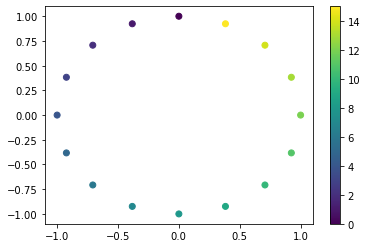

In [4]:
rotations = np.array([(np.pi/2 + n*np.pi/8)%(2*np.pi) for n in range(16)])
x = np.cos(rotations)
y = np.sin(rotations)
plt.scatter(x, y, c=list(range(len(x))))
plt.colorbar()

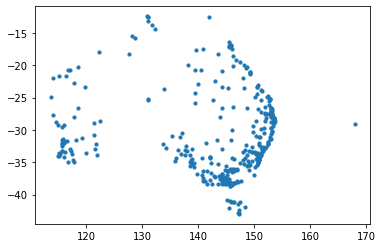

In [5]:
locations = utils.get_location_data()
plt.scatter(locations['lng'], locations['lat'], s=10)

In [6]:
df1 = pd.read_csv("weatherAUS.csv.zip")
df1 = utils.process_data(df1, cardinals_map)
df2 = pd.read_csv("weatherAUS_second_source.csv.zip")  # from https://rdrr.io/cran/rattle.data/man/weatherAUS.html
df2 = utils.process_data(df2, cardinals_map)
df = pd.concat([df1, df2])
del df1; del df2; gc.collect()
df.drop_duplicates(subset=["Date", "Location"], keep="first", inplace=True)
df.sort_values(by=["Date", "Location"], inplace=True, ignore_index=True)
df.drop(columns=["Date", "RainToday"], inplace=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205570 entries, 0 to 205569
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Location            205570 non-null  object 
 1   MinTemp             204483 non-null  float64
 2   MaxTemp             204928 non-null  float64
 3   Rainfall            203555 non-null  float64
 4   Evaporation         101671 non-null  float64
 5   Sunshine            91147 non-null   float64
 6   WindGustSpeed       191670 non-null  float64
 7   WindSpeed9am        202642 non-null  float64
 8   WindSpeed3pm        198938 non-null  float64
 9   Humidity9am         203259 non-null  float64
 10  Humidity3pm         198628 non-null  float64
 11  Pressure9am         183571 non-null  float64
 12  Pressure3pm         183603 non-null  float64
 13  Cloud9am            120568 non-null  float64
 14  Cloud3pm            113299 non-null  float64
 15  Temp9am             204373 non-nul

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0          Canberra      8.0     24.3       0.0          3.4       6.3   
1          Canberra     14.0     26.9       3.6          4.4       9.7   
2          Canberra     13.7     23.4       3.6          5.8       3.3   
3          Canberra     13.3     15.5      39.8          7.2       9.1   
4          Canberra      7.6     16.1       2.8          5.6      10.6   
...             ...      ...      ...       ...          ...       ...   
205565      Walpole     15.0     22.0       2.4          NaN       NaN   
205566     Watsonia      8.8     19.9       0.2          6.0       1.0   
205567  Williamtown     21.4     24.7       0.0          NaN       NaN   
205568  Witchcliffe     14.7     25.4       0.0          NaN       NaN   
205569      Woomera     15.2     32.5       0.0          NaN       NaN   

        WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  ...  \
0                30.0           6.0          20.0         68.0  ...   
1                39.0           4.0          17.0         80.0  ...   
2                85.0           6.0           6.0         82.0  ...   
3                54.0          30.0          24.0         62.0  ...   
4                50.0          20.0          28.0         68.0  ...   
...               ...           ...           ...          ...  ...   
205565           39.0          11.0          22.0         80.0  ...   
205566           22.0           6.0          11.0         98.0  ...   
205567           31.0          11.0          17.0         86.0  ...   
205568           48.0          24.0          30.0         60.0  ...   
205569           39.0          11.0          24.0         59.0  ...   

        Month_x_comp  Month_y_comp  WindGustDir_x_comp  WindGustDir_y_comp  \
0           0.874620     -0.484810        7.071068e-01            0.707107   
1           0.882948     -0.469472       -9.238795e-01            0.382683   
2           0.891007     -0.453990        7.071068e-01            0.707107   
3           0.898794     -0.438371        7.071068e-01            0.707107   
4           0.906308     -0.422618       -3.826834e-01           -0.923880   
...              ...           ...                 ...                 ...   
205565      0.052336      0.998630       -7.071068e-01           -0.707107   
205566      0.052336      0.998630        3.826834e-01           -0.923880   
205567      0.052336      0.998630       -9.238795e-01           -0.382683   
205568      0.052336      0.998630       -1.836970e-16           -1.000000   
205569      0.052336      0.998630        3.826834e-01           -0.923880   

        WindDir9am_x_comp  WindDir9am_y_comp  WindDir3pm_x_comp  \
0            7.071068e-01      -7.071068e-01           0.707107   
1           -1.000000e+00       1.224647e-16           1.000000   
2            6.123234e-17       1.000000e+00          -0.382683   
3            9.238795e-01       3.826834e-01           1.000000   
4           -3.826834e-01      -9.238795e-01          -0.923880   
...                   ...                ...                ...   
205565      -1.000000e+00       1.224647e-16          -0.707107   
205566      -1.836970e-16      -1.000000e+00           0.923880   
205567      -9.238795e-01       3.826834e-01          -0.923880   
205568      -9.238795e-01      -3.826834e-01          -0.382683   
205569      -7.071068e-01      -7.071068e-01           0.923880   

        WindDir3pm_y_comp      lat       lng  
0                0.707107 -35.2931  149.1269  
1                0.000000 -35.2931  149.1269  
2                0.923880 -35.2931  149.1269  
3                0.000000 -35.2931  149.1269  
4               -0.382683 -35.2931  149.1269  
...                   ...      ...       ...  
205565          -0.707107 -34.9777  116.7338  
205566          -0.382683 -37.7080  145.0830  
205567           0.382683 -32.8150  151.8428  
205568          -0.923880 -34.0261  115.1003  
205569    

In [7]:
df.describe().T

count         mean        std       min          25%  \
MinTemp             204483.0    12.163906   6.455025   -8.7000     7.500000   
MaxTemp             204928.0    23.352364   7.201863   -4.8000    18.000000   
Rainfall            203555.0     2.201064   8.054989    0.0000     0.000000   
Evaporation         101671.0     5.259083   3.435464    0.0000     2.600000   
Sunshine             91147.0     7.666357   3.767291    0.0000     4.900000   
WindGustSpeed       191670.0    40.154656  13.591801    2.0000    31.000000   
WindSpeed9am        202642.0    14.056864   8.888583    0.0000     7.000000   
WindSpeed3pm        198938.0    18.697182   8.753714    0.0000    13.000000   
Humidity9am         203259.0    68.432935  19.434777    0.0000    56.000000   
Humidity3pm         198628.0    50.908004  21.035469    0.0000    35.000000   
Pressure9am         183571.0  1017.649490   7.075773  979.1000  1012.900000   
Pressure3pm         183603.0  1015.234487   7.013484  977.1000  1010.400000   
Cloud9am            120568.0     4.593358   2.897947    0.0000     1.000000   
Cloud3pm            113299.0     4.598734   2.753125    0.0000     2.000000   
Temp9am             204373.0    17.019797   6.563083   -7.2000    12.300000   
Temp3pm             199737.0    21.795275   7.039178   -5.4000    16.700000   
RainTomorrow        205570.0     0.218091   0.412951    0.0000     0.000000   
Month_x_comp        205570.0     0.006813   0.706977   -1.0000    -0.694658   
Month_y_comp        205570.0    -0.009744   0.707140   -1.0000    -0.719340   
WindGustDir_x_comp  191573.0     0.024934   0.712752   -1.0000    -0.707107   
WindGustDir_y_comp  191573.0    -0.044634   0.699554   -1.0000    -0.707107   
WindDir9am_x_comp   190565.0    -0.020167   0.694561   -1.0000    -0.707107   
WindDir9am_y_comp   190565.0     0.012059   0.719054   -1.0000    -0.707107   
WindDir3pm_x_comp   197577.0     0.025861   0.712538   -1.0000    -0.707107   
WindDir3pm_y_comp   197577.0    -0.039428   0.700051   -1.0000    -0.707107   
lat                 205570.0   -32.775245   5.987126  -42.8806   -36.080600   
lng                 205570.0   142.079228  12.053570  115.1003   138.601100   

                             50%          75%          max  
MinTemp             1.200000e+01    16.900000    33.900000  
MaxTemp             2.280000e+01    28.400000    48.900000  
Rainfall            0.000000e+00     0.600000   371.000000  
Evaporation         4.600000e+00     7.200000   133.900000  
Sunshine            8.500000e+00    10.700000    14.500000  
WindGustSpeed       3.900000e+01    48.000000   135.000000  
WindSpeed9am        1.300000e+01    19.000000   130.000000  
WindSpeed3pm        1.900000e+01    24.000000    87.000000  
Humidity9am         6.900000e+01    83.000000   100.000000  
Humidity3pm         5.100000e+01    65.000000   100.000000  
Pressure9am         1.017600e+03  1022.400000  1041.100000  
Pressure3pm         1.015200e+03  1020.000000  1040.100000  
Cloud9am            5.000000e+00     7.000000     9.000000  
Cloud3pm            5.000000e+00     7.000000     9.000000  
Temp9am             1.680000e+01    21.600000    40.200000  
Temp3pm             2.120000e+01    26.600000    48.200000  
RainTomorrow        0.000000e+00     0.000000     1.000000  
Month_x_comp        1.745241e-02     0.707107     1.000000  
Month_y_comp       -1.745241e-02     0.694658     0.999848  
WindGustDir_x_comp  6.123234e-17     0.707107     1.000000  
WindGustDir_y_comp  0.000000e+00     0.707107     1.000000  
WindDir9am_x_comp  -1.836970e-16     0.707107     1.000000  
WindDir9am_y_comp   1.224647e-16     0.707107     1.000000  
WindDir3pm_x_comp   6.123234e-17     0.707107     1.000000  
WindDir3pm_y_comp   0.000000e+00     0.707107     1.000000  
lat                -3.393990e+01   -31.495800   -12.438100  
lng                 1.458389e+02   150.751100   167.954700

<AxesSubplot:>

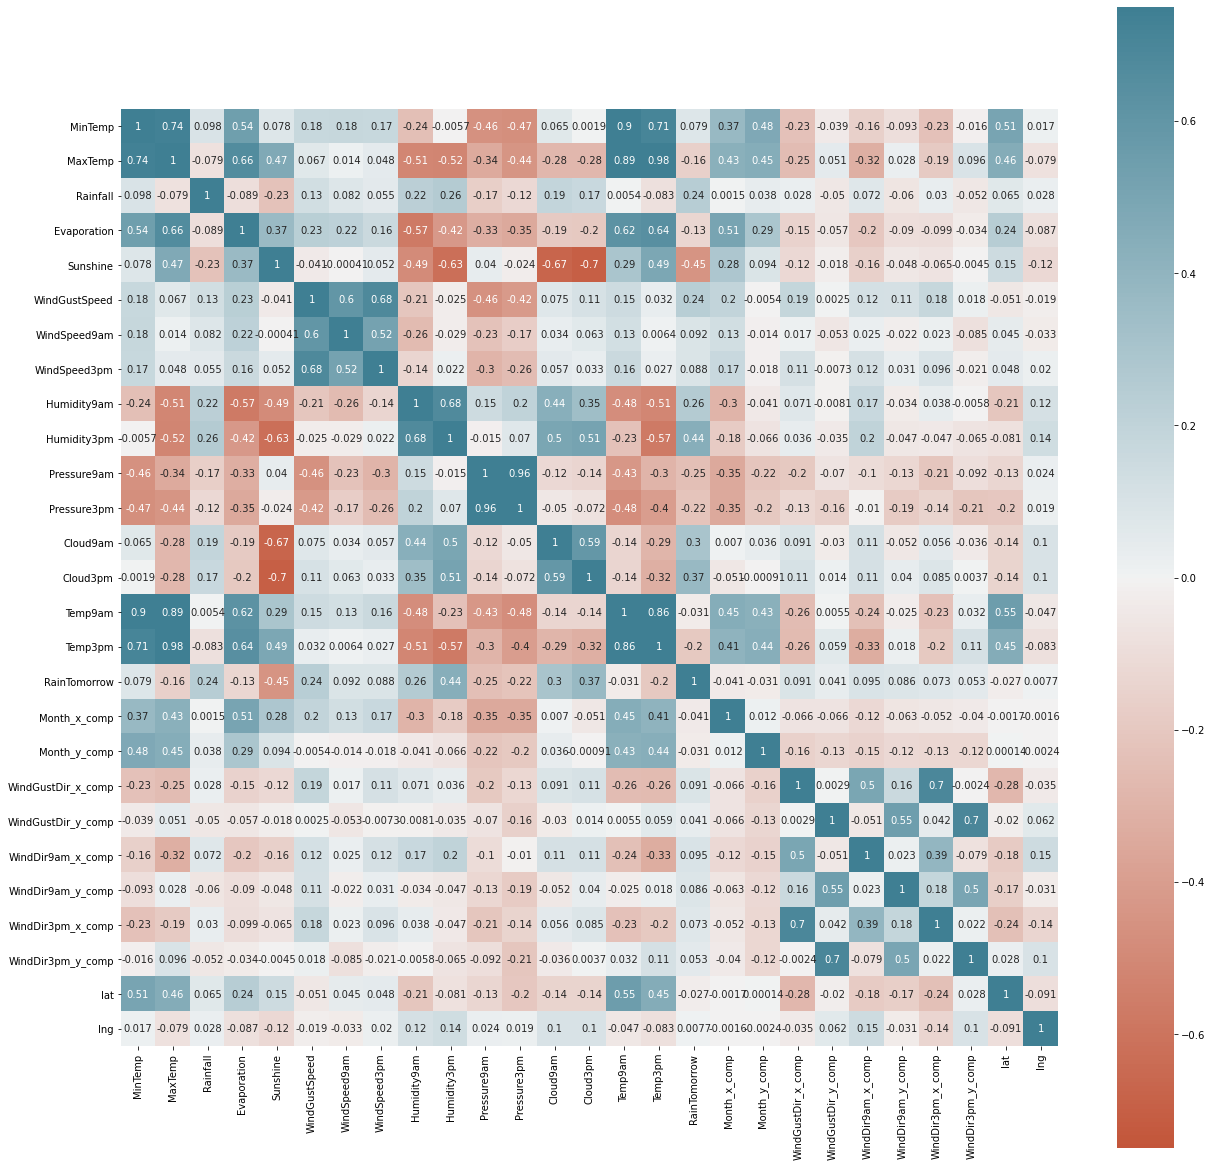

In [8]:
plt.figure(figsize=(21, 21))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2g',
            cmap=sns.diverging_palette(20, 220, n=256, as_cmap=True),
            vmin=-0.75, vmax=0.75)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["RainTomorrow"]), df["RainTomorrow"], test_size=0.25, shuffle=False
)

In [10]:
del df; gc.collect()

49

In [11]:
X_train["Evaporation"] = X_train.groupby("Location")["Evaporation"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 100)
X_train["Sunshine"] = X_train.groupby("Location")["Sunshine"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 25)
X_train["Cloud9am"] = X_train.groupby("Location")["Cloud9am"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 9)
X_train["Cloud3pm"] = X_train.groupby("Location")["Cloud3pm"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 9)

X_test["Evaporation"] = X_test.groupby("Location")["Evaporation"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 100)
X_test["Sunshine"] = X_test.groupby("Location")["Sunshine"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 25)
X_test["Cloud9am"] = X_test.groupby("Location")["Cloud9am"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 9)
X_test["Cloud3pm"] = X_test.groupby("Location")["Cloud3pm"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 9)

X_train.update(X_train.groupby("Location").ffill())
X_test.update(X_test.groupby("Location").ffill())

dry_reads = X_train.groupby("Location")["Rainfall"].apply(utils.running_zero_count_with_reset).rename("RunningDryReads")
X_train = X_train.merge(dry_reads, left_index=True, right_index=True)

dry_reads = X_test.groupby("Location")["Rainfall"].apply(utils.running_zero_count_with_reset).rename("RunningDryReads")
X_test = X_test.merge(dry_reads, left_index=True, right_index=True)

for col in X_train:
    X_train[col] = X_train[col].fillna(utils.DEFAULT_VALS.get(col, np.nan))

for col in X_test:
    X_test[col] = X_test[col].fillna(utils.DEFAULT_VALS.get(col, np.nan))

cols_to_lag = ["Temp9am", "Temp3pm", "Humidity9am", "Humidity3pm",
               "Pressure9am", "Pressure3pm", "FEAT1", "FEAT2", "FEAT3", "FEAT4"]

X_train = utils.feature_transformer(X_train)
X_test = utils.feature_transformer(X_test)

shifted = X_train.groupby("Location")[cols_to_lag].shift(1)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG1")
X_train = X_train.merge(shifted, left_index=True, right_index=True)

shifted = X_test.groupby("Location")[cols_to_lag].shift(1)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG1")
X_test = X_test.merge(shifted, left_index=True, right_index=True)

shifted = X_train.groupby("Location")[cols_to_lag].shift(2)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG2")
X_train = X_train.merge(shifted, left_index=True, right_index=True)

shifted = X_test.groupby("Location")[cols_to_lag].shift(2)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG2")
X_test = X_test.merge(shifted, left_index=True, right_index=True)

for col in cols_to_lag:
    X_train[f"{col}_LAG1"] = X_train[f"{col}_LAG1"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
    X_train[f"{col}_LAG2"] = X_train[f"{col}_LAG2"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
    X_test[f"{col}_LAG1"] = X_test[f"{col}_LAG1"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
    X_test[f"{col}_LAG2"] = X_test[f"{col}_LAG2"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
    
X_train.drop(columns=["WindDir9am_x_comp", "WindDir9am_y_comp",
                      "WindDir3pm_x_comp", "WindDir3pm_y_comp",
                      "WindGustDir_x_comp", "WindGustDir_y_comp"], inplace=True)

X_test.drop(columns=["WindDir9am_x_comp", "WindDir9am_y_comp",
                     "WindDir3pm_x_comp", "WindDir3pm_y_comp",
                     "WindGustDir_x_comp", "WindGustDir_y_comp"], inplace=True)

X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154177 entries, 0 to 154176
Data columns (total 59 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Location          154177 non-null  object 
 1   MinTemp           154177 non-null  float64
 2   MaxTemp           154177 non-null  float64
 3   Rainfall          154177 non-null  float64
 4   Evaporation       154177 non-null  float64
 5   Sunshine          154177 non-null  float64
 6   WindGustSpeed     154177 non-null  float64
 7   WindSpeed9am      154177 non-null  float64
 8   WindSpeed3pm      154177 non-null  float64
 9   Humidity9am       154177 non-null  float64
 10  Humidity3pm       154177 non-null  float64
 11  Pressure9am       154177 non-null  float64
 12  Pressure3pm       154177 non-null  float64
 13  Cloud9am          154177 non-null  float64
 14  Cloud3pm          154177 non-null  float64
 15  Temp9am           154177 non-null  float64
 16  Temp3pm           15

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0  Canberra      8.0     24.3       0.0          3.4       6.3           30.0   
1  Canberra     14.0     26.9       3.6          4.4       9.7           39.0   
2  Canberra     13.7     23.4       3.6          5.8       3.3           85.0   
3  Canberra     13.3     15.5      39.8          7.2       9.1           54.0   
4  Canberra      7.6     16.1       2.8          5.6      10.6           50.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  ...  Temp9am_LAG2  Temp3pm_LAG2  \
0           6.0          20.0         68.0  ...          15.0          20.0   
1           4.0          17.0         80.0  ...          15.0          20.0   
2           6.0           6.0         82.0  ...          14.4          23.6   
3          30.0          24.0         62.0  ...          17.5          25.7   
4          20.0          28.0         68.0  ...          15.4          20.2   

   Humidity9am_LAG2  Humidity3pm_LAG2  Pressure9am_LAG2  Pressure3pm_LAG2  \
0              70.0              60.0            1015.0            1015.0   
1              70.0              60.0            1015.0            1015.0   
2              68.0              29.0            1019.7            1015.0   
3              80.0              36.0            1012.4            1008.4   
4              82.0              69.0            1009.5            1007.2   

   FEAT1_LAG2  FEAT2_LAG2  FEAT3_LAG2  FEAT4_LAG2  
0        10.0    0.500000    1.000000         0.0  
1        10.0    0.500000    1.000000         0.0  
2        16.3    0.392638    0.957055        -4.7  
3        12.9    0.271318    0.906977        -4.0  
4         9.7    0.175258    0.670103        -2.3  

[5 rows x 59 columns]

In [12]:
X_train.describe().T

count         mean        std         min          25%  \
MinTemp           154177.0    12.197779   6.429521   -8.700000     7.600000   
MaxTemp           154177.0    23.338694   7.165946   -4.800000    18.000000   
Rainfall          154177.0     2.274910   8.215484    0.000000     0.000000   
Evaporation       154177.0     3.423845   3.656419    0.000000     0.000000   
Sunshine          154177.0     4.813082   4.778660    0.000000     0.000000   
WindGustSpeed     154177.0    40.140151  13.225936    2.000000    31.000000   
WindSpeed9am      154177.0    14.055547   8.882474    0.000000     7.000000   
WindSpeed3pm      154177.0    18.948352   9.105402    0.000000    13.000000   
Humidity9am       154177.0    68.617401  19.292303    0.000000    57.000000   
Humidity3pm       154177.0    51.078987  20.946710    0.000000    36.000000   
Pressure9am       154177.0  1017.276638   6.785861  980.500000  1013.300000   
Pressure3pm       154177.0  1015.103627   6.679284  977.100000  1010.900000   
Cloud9am          154177.0     4.465176   2.472602    0.000000     3.000000   
Cloud3pm          154177.0     4.419741   2.345110    0.000000     3.000000   
Temp9am           154177.0    17.024294   6.555533   -7.200000    12.300000   
Temp3pm           154177.0    21.768674   7.008885   -5.400000    16.600000   
Month_x_comp      154177.0     0.009609   0.706608   -1.000000    -0.694658   
Month_y_comp      154177.0    -0.011093   0.707458   -1.000000    -0.719340   
lat               154177.0   -32.740549   6.046274  -42.880600   -36.080600   
lng               154177.0   142.070761  12.066786  115.100300   138.601100   
RunningDryReads   154177.0     0.058051   0.185267    0.000000     0.000000   
FEAT1             154177.0    11.140915   4.946141    0.100000     7.300000   
FEAT2             154177.0     0.431440   0.173145    0.000000     0.312500   
FEAT3             154177.0     0.822808   0.179078    0.000000     0.781818   
FEAT4             154177.0    -2.173011   2.026594  -19.200000    -3.600000   
FEAT5             154177.0   -17.538414  16.635224  -91.000000   -29.000000   
FEAT6             154177.0     8.530784  11.600064    1.098612     1.163151   
FEAT7             154177.0    26.066433  38.292034    0.000000     0.000000   
FEAT8             154177.0     2.625149  29.582359 -135.000000   -21.920310   
FEAT9             154177.0    -1.697246  28.681828 -135.000000   -24.748737   
FEAT10            154177.0    -0.075352  11.424970  -66.519326    -7.270985   
FEAT11            154177.0     1.061817  15.021685  -61.518290   -10.162675   
FEAT12            154177.0     0.099709  12.079342  -87.000000    -7.270985   
FEAT13            154177.0    -1.240004  14.616178  -74.000000   -12.010434   
FEAT14            154177.0    10.217320   4.188469    0.000000     7.200000   
FEAT15            154177.0     0.997866   0.001995    0.981246     0.996486   
FEAT16            154177.0     0.942323   0.535522    0.000000     0.641854   
FEAT17            154177.0     0.207253   0.388262    0.000000     0.000000   
Temp9am_LAG1      154177.0    17.022422   6.554778   -7.200000    12.300000   
Temp3pm_LAG1      154177.0    21.766797   7.007981   -5.400000    16.600000   
Humidity9am_LAG1  154177.0    68.618121  19.289879    0.000000    57.000000   
Humidity3pm_LAG1  154177.0    51.082769  20.944110    0.000000    36.000000   
Pressure9am_LAG1  154177.0  1017.277290   6.785272  980.500000  1013.300000   
Pressure3pm_LAG1  154177.0  1015.104670   6.678613  977.100000  1010.900000   
FEAT1_LAG1        154177.0    11.140588   4.945535    0.100000     7.300000   
FEAT2_LAG1        154177.0     0.431480   0.173114    0.000000     0.312500   
FEAT3_LAG1        154177.0     0.822873   0.179078    0.000000     0.781818   
FEAT4_LAG1        154177.0    -2.172620   2.026710  -19.200000    -3.600000   
Temp9am_LAG2      154177.0    17.020510   6.554124   -7.200000    12.300000   
Temp3pm_LAG2      154177.0    21.764504   7.006768   -5.400000    16.60

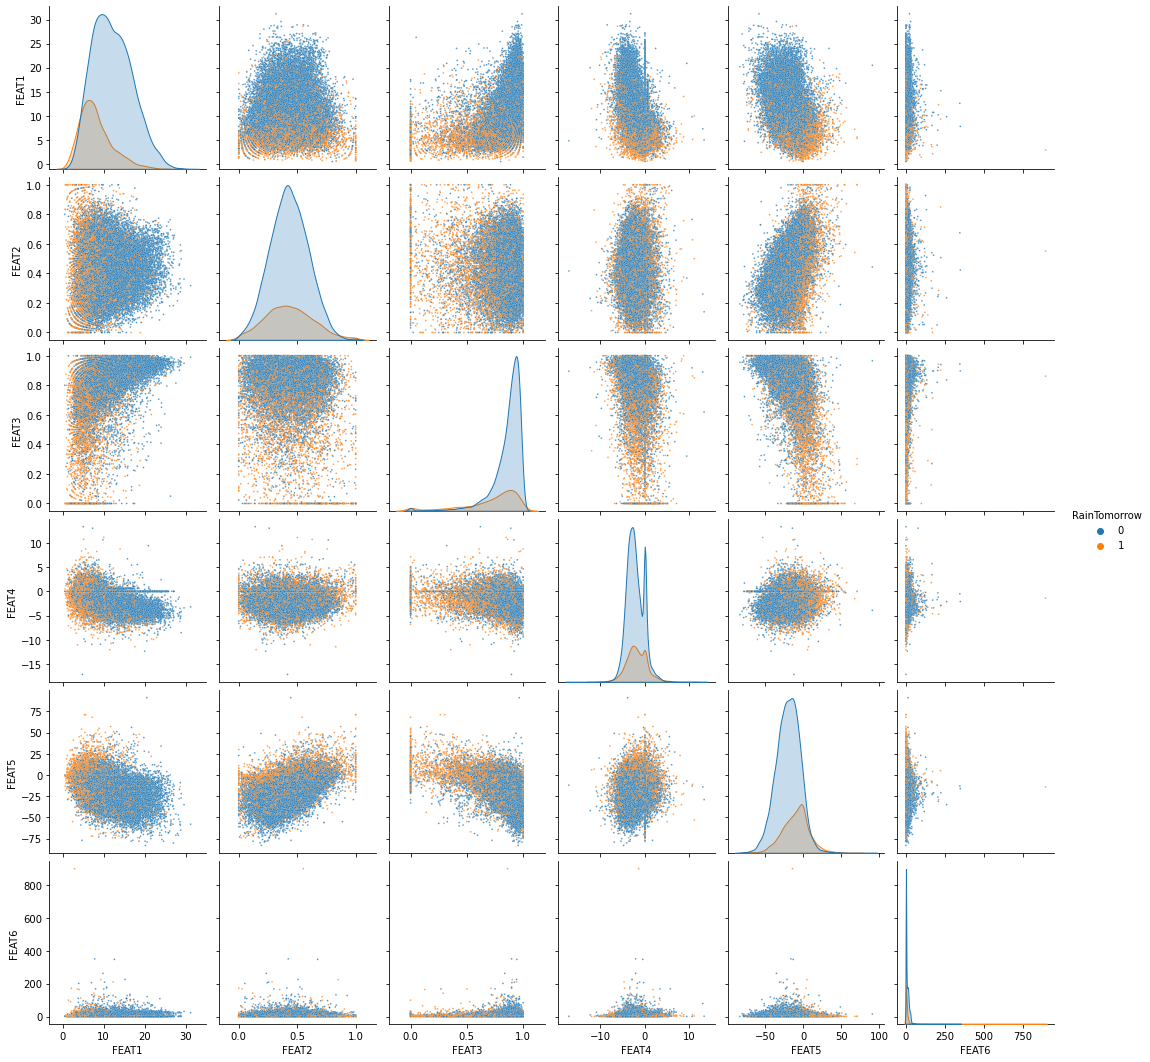

In [13]:
sns.pairplot(X_train.merge(y_train, left_index=True, right_index=True)[[col for col in X_train if "FEAT" in col][:6] + ["RainTomorrow"]].sample(25000),
             hue="RainTomorrow",
             plot_kws={"alpha": 0.75, "s": 3})

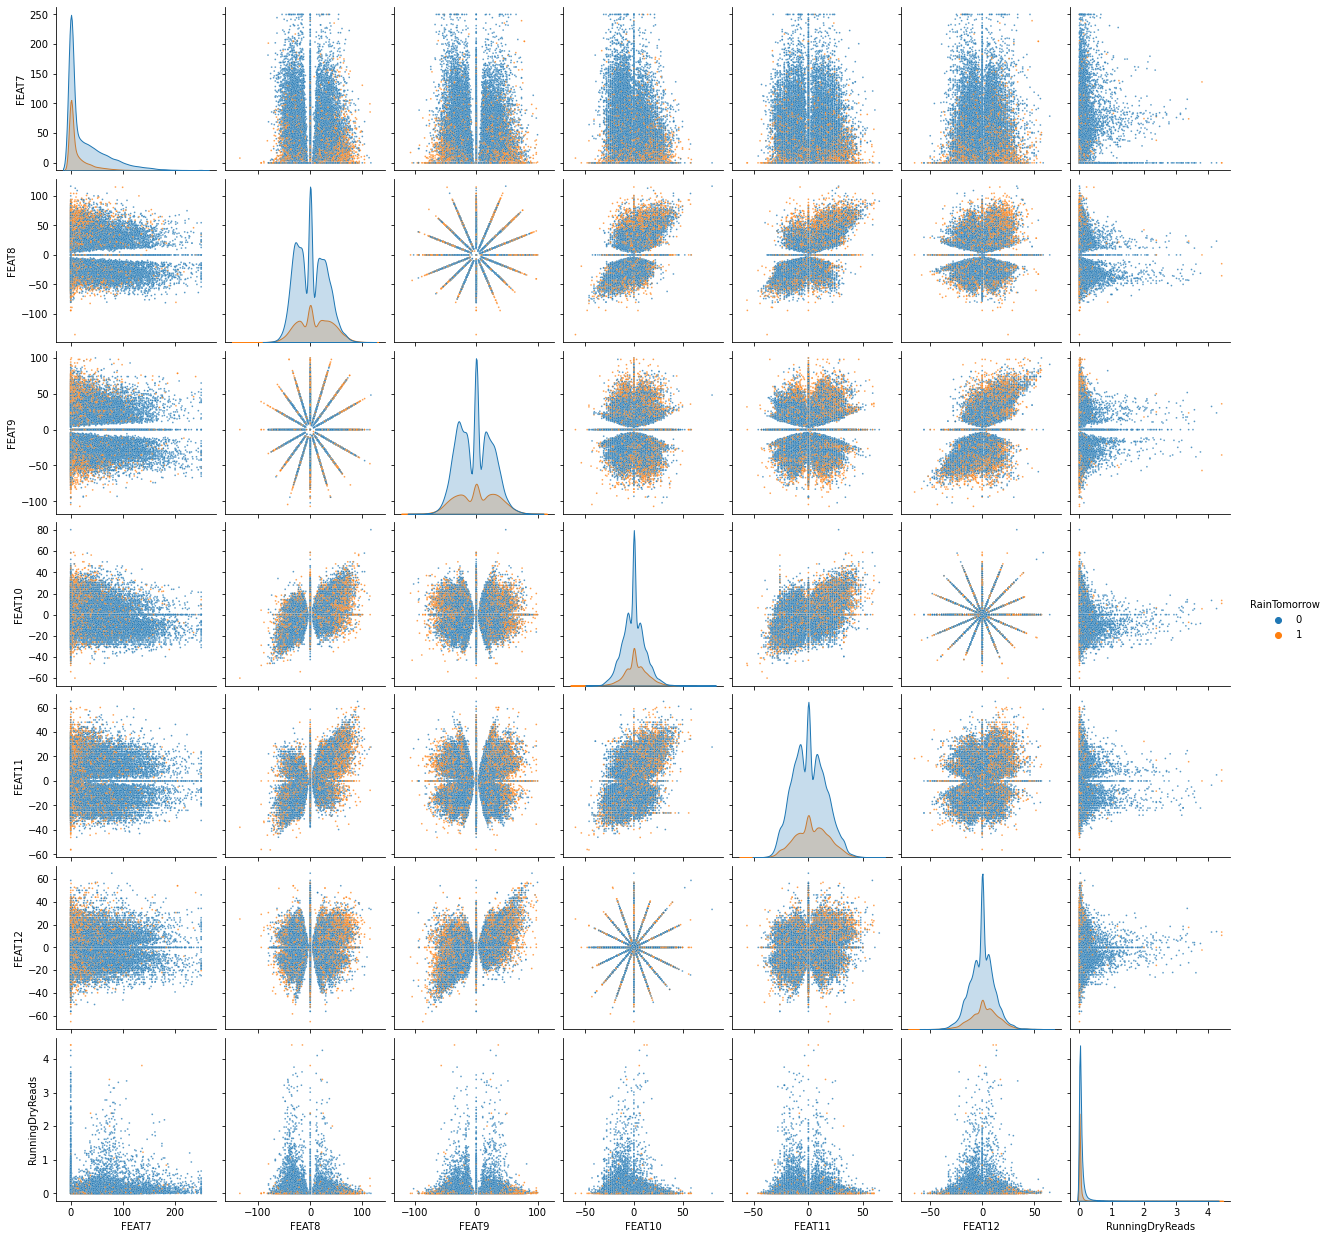

In [14]:
sns.pairplot(X_train.merge(y_train,
                           left_index=True,
                           right_index=True)[[col for col in X_train if "FEAT" in col][6:12] + ["RainTomorrow"] + ["RunningDryReads"]].sample(50000),
             hue="RainTomorrow",
             plot_kws={"alpha": 0.75, "s": 3})

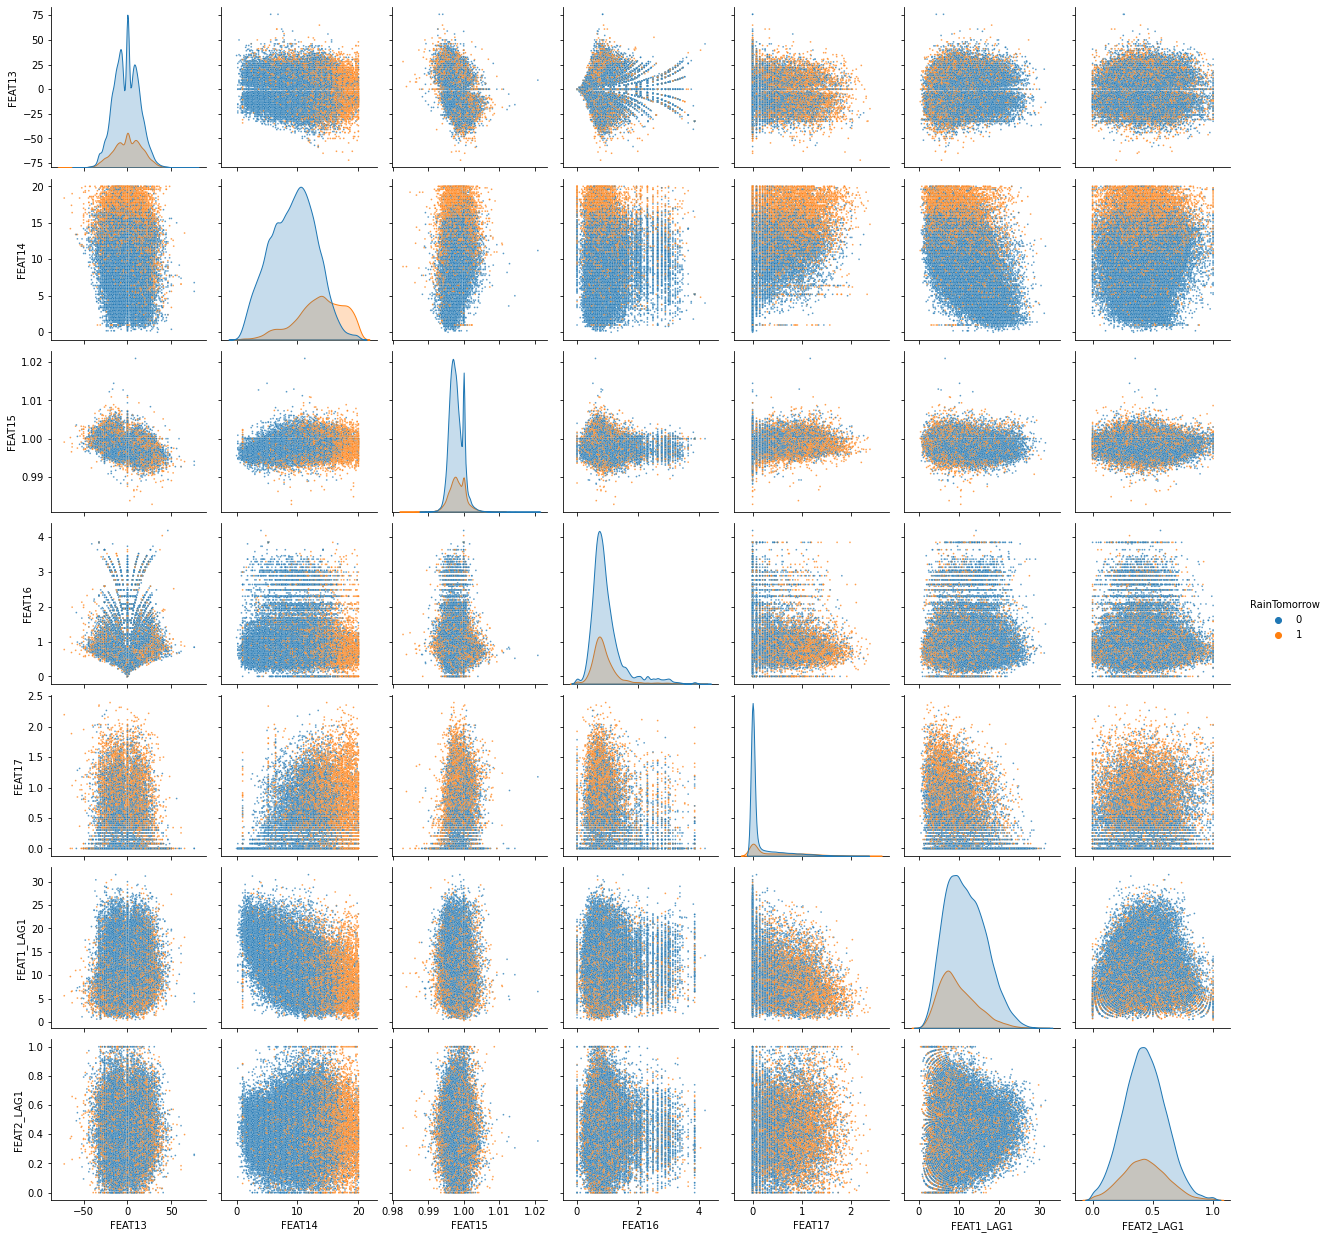

In [15]:
sns.pairplot(X_train.merge(y_train, left_index=True, right_index=True)[[col for col in X_train if "FEAT" in col][12:19] + ["RainTomorrow"]].sample(50000),
             hue="RainTomorrow",
             plot_kws={"alpha": 0.75, "s": 3})

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154177 entries, 0 to 154176
Data columns (total 59 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Location          154177 non-null  object 
 1   MinTemp           154177 non-null  float64
 2   MaxTemp           154177 non-null  float64
 3   Rainfall          154177 non-null  float64
 4   Evaporation       154177 non-null  float64
 5   Sunshine          154177 non-null  float64
 6   WindGustSpeed     154177 non-null  float64
 7   WindSpeed9am      154177 non-null  float64
 8   WindSpeed3pm      154177 non-null  float64
 9   Humidity9am       154177 non-null  float64
 10  Humidity3pm       154177 non-null  float64
 11  Pressure9am       154177 non-null  float64
 12  Pressure3pm       154177 non-null  float64
 13  Cloud9am          154177 non-null  float64
 14  Cloud3pm          154177 non-null  float64
 15  Temp9am           154177 non-null  float64
 16  Temp3pm           15

<AxesSubplot:>

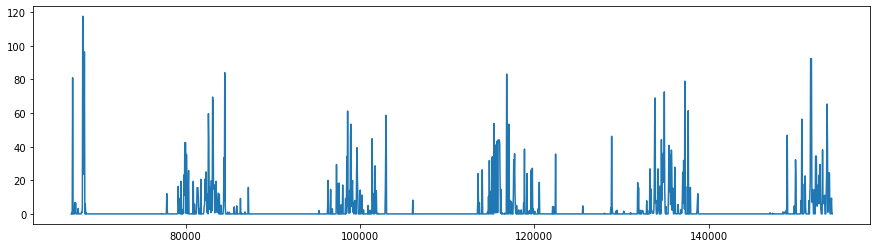

In [17]:
X_train[X_train['Location'] == "Katherine"]["Rainfall"].plot(figsize=(15, 4))

<AxesSubplot:>

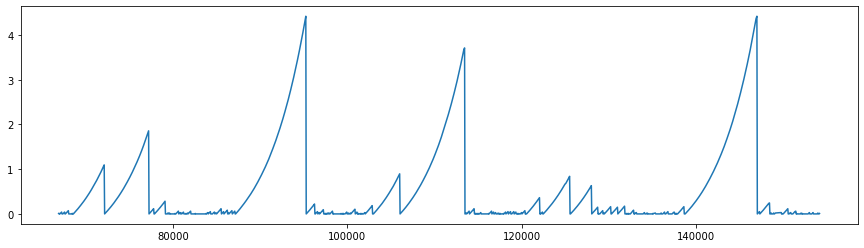

In [18]:
X_train[X_train['Location'] == "Katherine"]["RunningDryReads"].plot(figsize=(15, 4))

In [19]:
param_distribs = {
    "n_estimators": [250, 300, 350, 400, 450, 500, 550, 600],
    "max_depth": [6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
    "num_leaves": [25, 30, 35, 40, 45, 50, 55, 60],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "reg_lambda": [0, 0.5, 1, 5, 10, 25, 50, 75, 100, 150, 200]
}

clf = lgb.LGBMClassifier(n_jobs=-1, random_state=0, silent=False)
ts_cv = TimeSeriesSplit(n_splits=4)
searcher = RandomizedSearchCV(
    clf,
    param_distributions=param_distribs,
    n_iter=75,
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=ts_cv,
    random_state=0
)
searcher.fit(X_train.drop(columns=["Location"]), y_train)

[LightGBM] [Info] Number of positive: 34365, number of negative: 119812
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12464
[LightGBM] [Info] Number of data points in the train set: 154177, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222893 -> initscore=-1.248885
[LightGBM] [Info] Start training from score -1.248885


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=LGBMClassifier(random_state=0, silent=False),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'max_depth': [6, 8, 10, 12, 14, 16, 18,
                                                      20, 22, 24],
                                        'n_estimators': [250, 300, 350, 400,
                                                         450, 500, 550, 600],
                                        'num_leaves': [25, 30, 35, 40, 45, 50,
                                                       55, 60],
                                        'reg_lambda': [0, 0.5, 1, 5, 10, 25, 50,
                                                       75, 100, 150, 200],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   random_state=0, scoring='balanc

In [20]:
pd.DataFrame(searcher.cv_results_).drop(columns=['params']).sort_values(by="rank_test_score").head(25)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
34      32.891291     10.978267         4.758587        0.432168   
29      24.868703      7.019489         3.586531        0.139459   
30      37.928598     13.327175         5.279527        0.312333   
37      40.703999     11.934291         5.712099        0.237546   
59      31.503196     11.375032         4.534996        0.632426   
9       34.535408     12.963611         5.080874        0.390805   
13      56.283957     21.776187         9.102731        2.241783   
38      27.346034      9.761453         3.439236        0.048815   
28      37.693353     11.749260         5.441806        0.348129   
47      50.787662     15.791551         8.814300        0.504285   
56      43.998862     12.199782         7.099560        0.536842   
22      46.294095     15.431051         6.337395        0.147038   
8       30.226317      9.103169         4.087921        0.215923   
43      38.087103      8.672752         5.160684        0.426859   
60      46.830983     17.063115         7.401049        0.985401   
12      38.784536     12.482412         6.316155        0.888823   
17      32.377291      8.705963         4.191397        0.523588   
54      48.217964     13.332625         7.180890        0.204507   
7       35.976428      8.304194         4.564535        0.402988   
21      26.284799      8.631984         3.407654        0.128307   
2       21.962125      8.474493         3.033024        0.344233   
70      27.913912      8.927934         3.708928        0.126696   
71      37.650113     11.406742         5.017758        0.736789   
46      31.175978     10.617991         4.637076        0.142494   
40      28.672454      9.303091         4.609056        1.007879   

   param_subsample param_reg_lambda param_num_leaves param_n_estimators  \
34             0.8              100               35                600   
29             0.6               75               40                450   
30             0.6              200               40                600   
37             0.7              150               45                550   
59               1              200               45                400   
9              0.9              200               50                400   
13             0.7              200               50                500   
38             0.9              200               35                400   
28             0.8              150               50                550   
47             0.5              150               60                600   
56             0.8               75               60                550   
22               1              200               30                600   
8              0.7               75               55                350   
43             0.6               75               50                450   
60             0.7              200               55                550   
12               1               50               60                400   
17             0.7               75               55                300   
54             0.7              150               60                550   
7              0.9              100               30                500   
21             0.7              150               45                300   
2              0.6               75               45                300   
70               1              100               50                300   
71             0.9              100               40                450   
46             0.7              200               50                550   
40               1               50               30                550   

   param_max_depth  split0_test_score  split1_test_score  split2_test_score  \
34              16           0.753875           0.764242           0.735081   
29              20           0.753857           0.765291           0.734616   
30              20           0.754049          

In [21]:
graph = lgb.create_tree_digraph(searcher.best_estimator_)
graph.render(filename="more_feature_eng")

'more_feature_eng.pdf'

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     40925
           1       0.74      0.57      0.65     10468

    accuracy                           0.87     51393
   macro avg       0.82      0.76      0.78     51393
weighted avg       0.86      0.87      0.87     51393



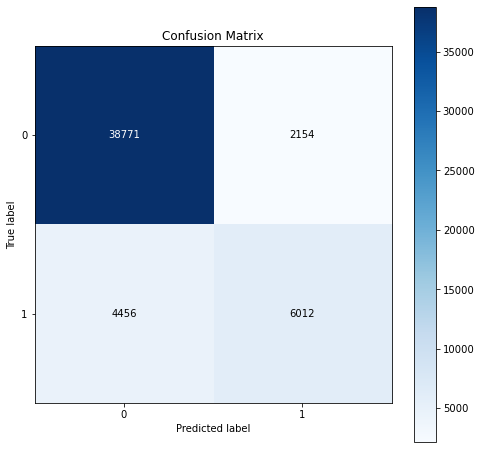

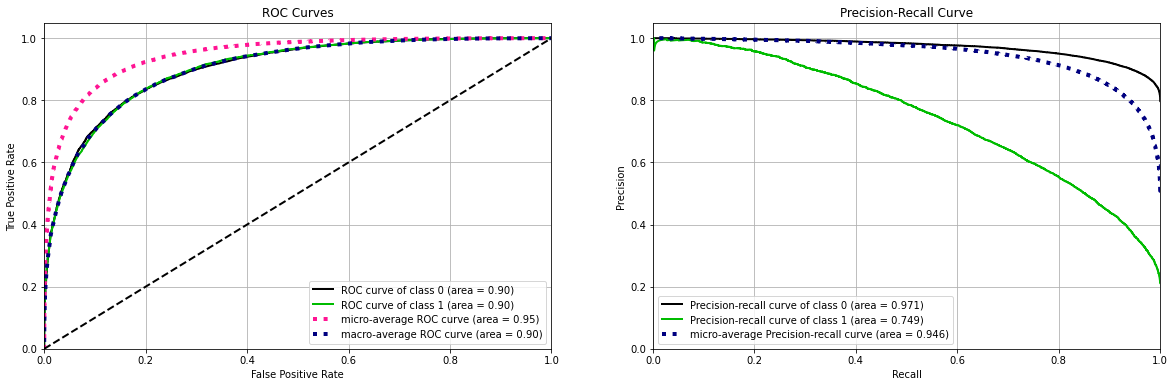

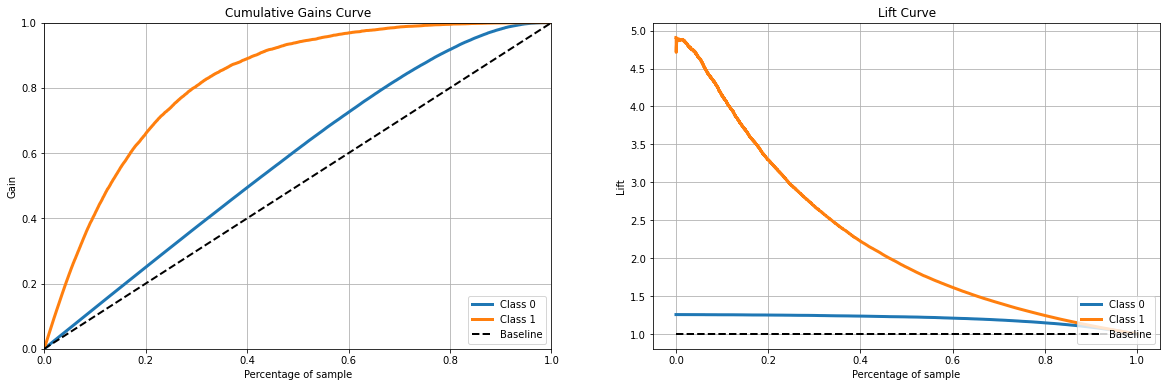

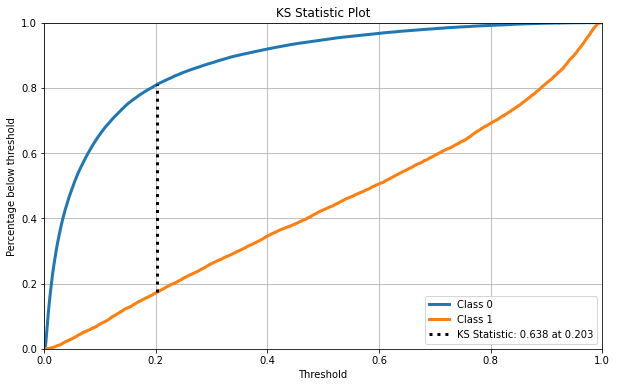

In [22]:
utils.evaluate_binary_clf(
    X_test.drop(columns=["Location"]),
    y_test,
    searcher.best_estimator_
)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

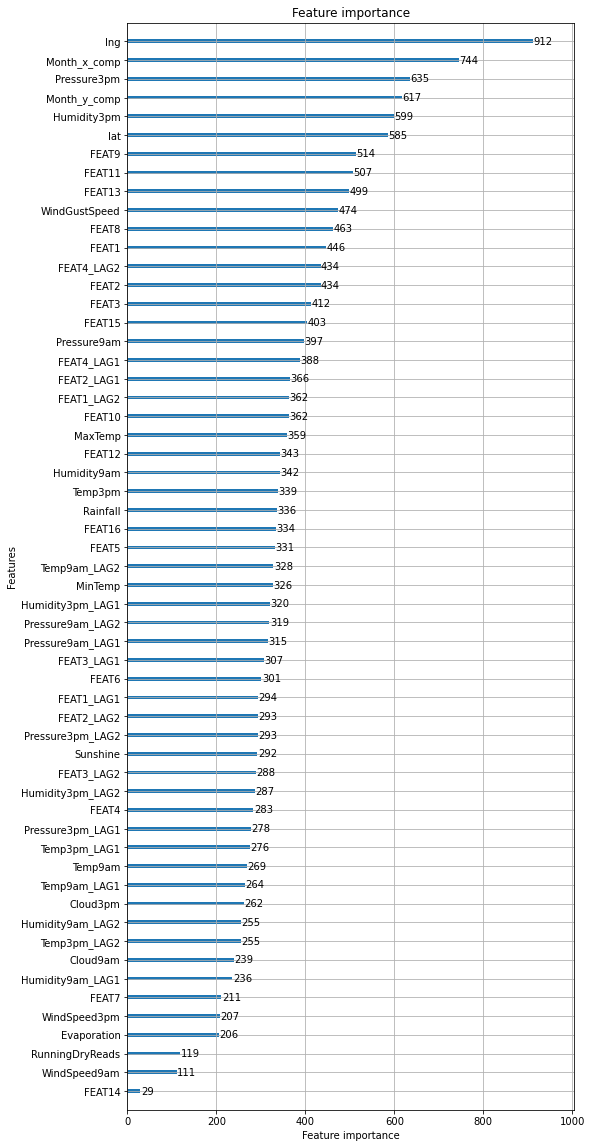

In [23]:
lgb.plot_importance(searcher.best_estimator_, figsize=(8, 20))

In [24]:
roc_auc_score(y_test, searcher.best_estimator_.predict(X_test.drop(columns=["Location"])))

0.7608444387281226